In [17]:
!pip install --upgrade pip
!pip install numpy~=1.0  # 1.0 instead of 2.0 for pymatching compatibility later
!pip install scipy
!pip install stim~=1.14
!pip install pymatching~=2.0
!pip install qiskit

In [18]:
import stim
print(stim.__version__)

1.14.0


In [19]:
import stim
import pymatching
import numpy as np
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [20]:
import stim
def get_logical_err_rate(distance: int, rounds: int, phy_err_p: int, num_shots: int) -> float:
    # Generate Surface Code circuit with the specified parameters.
    circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=rounds,
            distance=distance,
            after_clifford_depolarization=phy_err_p,
            after_reset_flip_probability=phy_err_p,
            before_measure_flip_probability=phy_err_p,
            before_round_data_depolarization=phy_err_p,
        )
    return count_logical_errors(circuit, num_shots) / num_shots

In [21]:
print(get_logical_err_rate(distance=7, rounds=21, phy_err_p=0.001, num_shots=100000))

9e-05


In [22]:
def get_distance_from_logical_err_rate(logical_err_rate: float, phy_err_p: int) -> int:
    # Binary search for the distance that gives the desired logical error rate.
    num_shots = int(10 / logical_err_rate)
    high = 2
    while get_logical_err_rate(high, high * 3, phy_err_p, num_shots) > logical_err_rate:
        high *= 2
    low = max(high // 2, 2)
    while low < high:
        mid = (low + high) // 2
        err_rate = get_logical_err_rate(mid, mid * 3, phy_err_p, num_shots)
        if err_rate < logical_err_rate:
            high = mid
        else:
            low = mid + 1
    return high

In [23]:
print(get_distance_from_logical_err_rate(logical_err_rate=0.0001, phy_err_p=0.001))

7


In [24]:
class PhysicalQubit:
    def __init__(self, gate_error_rate, measurement_error_rate, 
                 single_qubit_gate_time=50e-9, two_qubit_gate_time=100e-9, measurement_time=2600e-9):
        self.single_qubit_gate_time = single_qubit_gate_time
        self.two_qubit_gate_time = two_qubit_gate_time      
        self.gate_error_rate = gate_error_rate              
        self.measurement_time = measurement_time
        self.measurement_error_rate = measurement_error_rate

In [25]:
class SurfaceCode:
    def __init__(self, code_distance, physical_qubit_params):
        self.code_distance = code_distance
        self.physical_qubit = physical_qubit_params
        self.logical_cycle_time = 3 * self.code_distance * (4 * self.physical_qubit.two_qubit_gate_time + 2 * self.physical_qubit.measurement_time)

    def logical_error_rate(self):
        p_physical = self.physical_qubit.gate_error_rate
        return p_physical ** (self.code_distance / 2)

    def physical_qubits_per_logical(self):
        return 2 * self.code_distance ** 2 - 1

In [26]:
class TFactory:
    def __init__(self, surface_code, distillation_level=1):
        self.surface_code = surface_code
        self.distillation_level = distillation_level
        self.t_round = 10 * self.surface_code.logical_cycle_time
        self.t_distillation = self.distillation_level * self.t_round
        self.t_gate_per_second = 1 / self.t_distillation

    def required_physical_qubits(self, max_runtime, t_count):
        required_t_per_second = t_count / max_runtime
        num_t_factories = max(int(np.ceil(required_t_per_second / self.t_gate_per_second)), 1)
        num_logical_qubits = num_t_factories * 15
        return num_logical_qubits * self.surface_code.physical_qubits_per_logical()

    def distillation_time(self):
        return self.t_distillation

In [27]:
class Algorithm:
    def __init__(self, t_gates, one_q_gates, two_q_gates, qubits, total_cycles):
        self.t_gates = t_gates         
        self.one_q_gates = one_q_gates
        self.two_q_gates = two_q_gates
        self.qubits = qubits
        self.total_cycles = total_cycles

In [28]:
class ResourceEstimator:
    def __init__(self, algorithm, surface_code, t_factory):
        self.algorithm = algorithm
        self.surface_code = surface_code
        self.t_factory = t_factory

    def estimate(self):
        logical_qubits = self.algorithm.qubits
        total_time = self.algorithm.total_cycles * self.surface_code.logical_cycle_time
        circuit_physical = logical_qubits * self.surface_code.physical_qubits_per_logical()
        t_physical = self.t_factory.required_physical_qubits(total_time, self.algorithm.t_gates)
        return {
            "logical_qubits": logical_qubits,
            "circuit_physical_qubits": circuit_physical,
            "t_factory_physical_qubits": t_physical, 
            "total_time_seconds": total_time
        }

In [29]:
import qiskit
from qiskit import QuantumCircuit

def estimate_circuit_cost(circ: QuantumCircuit):
    num_qubits = circ.num_qubits
    num_gates = circ.size()
    logical_cycles = circ.depth()
    print(f"num qubits: {num_qubits}, num gates: {num_gates}, logical cycles: {logical_cycles}")
    logical_error_rate = 0.5 / logical_cycles
    distance = get_distance_from_logical_err_rate(logical_error_rate, 3.36e-3)
    print(f"code distance: {distance}")
    physical_qubit = PhysicalQubit(gate_error_rate=3.36e-3, measurement_error_rate=7.813e-3)
    surface_code = SurfaceCode(code_distance=distance, physical_qubit_params=physical_qubit)
    t_factory = TFactory(surface_code=surface_code, distillation_level=1)
    t_gates = circ.count_ops().get('t', 0)
    one_q_gates = sum([circ.count_ops().get(op, 0) for op in ['x', 'y', 'z', 'h', 's', 't']])
    two_q_gates = sum([circ.count_ops().get(op, 0) for op in ['cp', 'cx', 'swap']])
    print(f"t gates: {t_gates}, one q gates: {one_q_gates}, two q gates: {two_q_gates}, qubits: {num_qubits}, logical cycles: {logical_cycles}")
    algorithm = Algorithm(t_gates=t_gates, one_q_gates=one_q_gates, two_q_gates=two_q_gates, total_cycles=circ.depth(), qubits=circ.num_qubits)
    estimator = ResourceEstimator(algorithm, surface_code, t_factory)
    result = estimator.estimate()    
    return {"logical_qubits": result["logical_qubits"],
            "circuit_physical_qubits": result["circuit_physical_qubits"],
            "t_factory_physical_qubits": result["t_factory_physical_qubits"],
            "total_time_seconds": result["total_time_seconds"]}

In [30]:
import qiskit
from qiskit import QuantumCircuit
from qiskit import qpy
global syned_qc
result = {10: [], 12: [], 14: []}
for num in [10, 12, 14]:
    for id in range(3, 10):
        with open(f"opt_syned_qc/{num}_{id}.qasm", "rb") as f:
            syned_qc = qpy.load(f)[0]
        print(f"qc_{num}_{id}")
        result[num].append(estimate_circuit_cost(syned_qc))
        print(result[num][-1])

qc_10_3
num qubits: 10, num gates: 4564, logical cycles: 1485
code distance: 15
t gates: 1580, one q gates: 4148, two q gates: 90, qubits: 10, logical cycles: 1485
{'logical_qubits': 10, 'circuit_physical_qubits': 4490, 't_factory_physical_qubits': 74085, 'total_time_seconds': 0.37422000000000005}
qc_10_4
num qubits: 10, num gates: 5458, logical cycles: 2146
code distance: 15
t gates: 1936, one q gates: 4970, two q gates: 120, qubits: 10, logical cycles: 2146
{'logical_qubits': 10, 'circuit_physical_qubits': 4490, 't_factory_physical_qubits': 67350, 'total_time_seconds': 0.5407920000000002}
qc_10_5
num qubits: 10, num gates: 7188, logical cycles: 3962
code distance: 17
t gates: 2467, one q gates: 6528, two q gates: 150, qubits: 10, logical cycles: 3962
{'logical_qubits': 10, 'circuit_physical_qubits': 5770, 't_factory_physical_qubits': 60585, 'total_time_seconds': 1.1315472}
qc_10_6
num qubits: 10, num gates: 7413, logical cycles: 3900
code distance: 17
t gates: 2620, one q gates: 6712

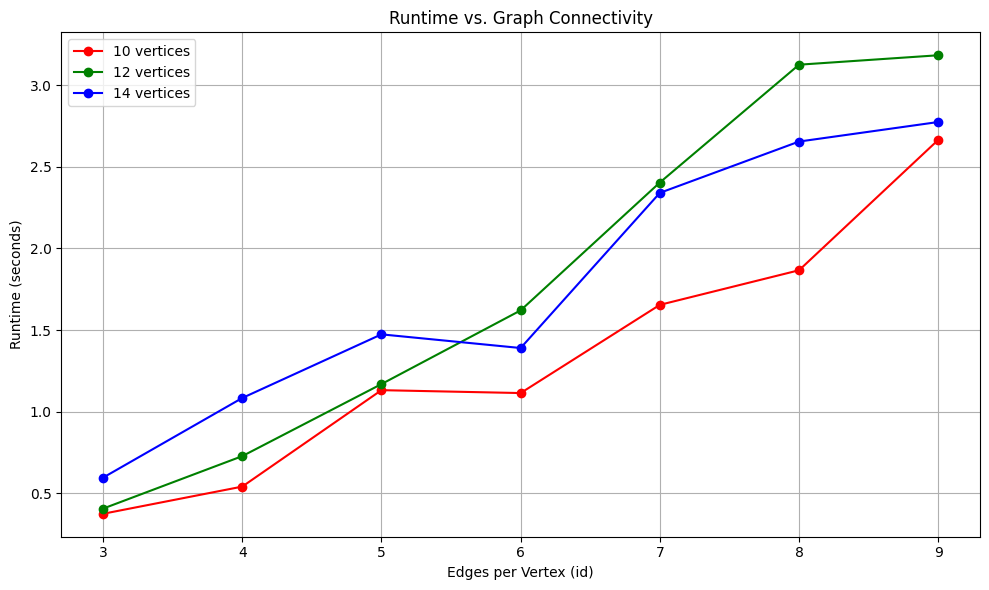

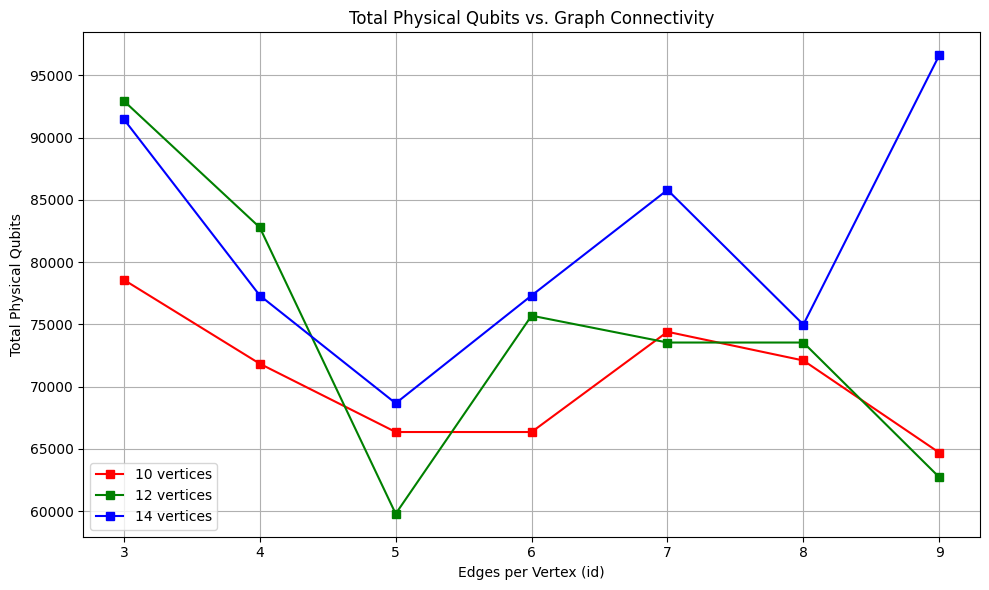

In [31]:
import matplotlib.pyplot as plt

# Visualization setup
colors = {10: 'r', 12: 'g', 14: 'b'}
labels = {10: '10 vertices', 12: '12 vertices', 14: '14 vertices'}

# Extract x-axis (ids) and prepare data containers
x_vals = list(range(3, 10))  # ids: edges per vertex

# Plot 1: Runtime vs. id
plt.figure(figsize=(10, 6))
for num in [10, 12, 14]:
    runtimes = [entry["total_time_seconds"] for entry in result[num]]
    plt.plot(x_vals, runtimes, marker='o', color=colors[num], label=labels[num])

plt.xlabel("Edges per Vertex (id)")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs. Graph Connectivity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Total physical qubits vs. id
plt.figure(figsize=(10, 6))
for num in [10, 12, 14]:
    total_qubits = [entry["circuit_physical_qubits"] + entry["t_factory_physical_qubits"] for entry in result[num]]
    plt.plot(x_vals, total_qubits, marker='s', color=colors[num], label=labels[num])

plt.xlabel("Edges per Vertex (id)")
plt.ylabel("Total Physical Qubits")
plt.title("Total Physical Qubits vs. Graph Connectivity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
